In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib.colors import LinearSegmentedColormap
import future.utils
import json
import numpy as np
import tqdm
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
sns.set_style("whitegrid")

In [ ]:
print('matplotlib: {}'. format(mpl.__version__))

In [ ]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

heatmap_hex_list = ['#357db0', '#ce2626']
heatmap_cmap=get_continuous_cmap(heatmap_hex_list)

spaghetti_hex_list = ['#357db0', '#18A558', '#ce2626']
spaghetti_cmap=get_continuous_cmap(spaghetti_hex_list)



In [ ]:
def from_res_to_iterations(name, nr):
    res = open("res/{}.csv".format(name))
    iterations = []
    it = 0
    for line in res.readlines():
        iterations.append(dict())
        iterations[it]['iteration'] = it
        iterations[it]['status'] = dict()

        opinions = line.strip().split(',')

        for i in range(len(opinions)):
            iterations[it]['status'][i] = float(opinions[i])
            iterations[it]['node_count'] = {0: 0},
            iterations[it]['status_delta'] = {0: 0}

        it += 1
        
    return iterations

def evolution(iterations, hex_list, fig, ax):

    spaghetti_hex_list = ['#357db0', '#18A558', '#ce2626']


    """
    Generates the plot

    :param filename: Output filename
    :param percentile: The percentile for the trend variance area
    """

    nodes2opinions = {}
    node2col = {}

    last_it = iterations[-1]['iteration'] + 1
    last_seen = {}

    for it in iterations:
        sts = it['status']
        its = it['iteration']
        for n, v in sts.items():
            if n in nodes2opinions:
                last_id = last_seen[n]
                last_value = nodes2opinions[n][last_id]

                for i in range(last_id, its):
                    nodes2opinions[n][i] = last_value

                nodes2opinions[n][its] = v
                last_seen[n] = its
            else:
                nodes2opinions[n] = [0]*last_it
                nodes2opinions[n][its] = v
                last_seen[n] = 0
                if v < 0.33:
                    node2col[n] = spaghetti_hex_list[0]
                elif 0.33 <= v <= 0.66:
                    node2col[n] = spaghetti_hex_list[1]
                else:
                    node2col[n] = spaghetti_hex_list[2]

    mx = 0
    for k, l in future.utils.iteritems(nodes2opinions):
        if mx < last_seen[k]:
            mx = last_seen[k]
        x = list(range(0, last_seen[k]))
        y = l[0:last_seen[k]]
        ax.plot(x, y, lw=1.5, alpha=0.5, color=node2col[k])
    
    # ax.set_ylim(-0.1, 1.1)
    # ax.set_xlim(0, 1000)
    # ax.tick_params(axis='both', which='major', labelsize=4, pad=0) 
    # ax.set_xlabel("o", fontsize=5)
    # ax.set_ylabel("t", fontsize=5)               
    # plt.grid(axis = 'both', which='both')
    plt.tight_layout()

    
from tqdm import tqdm

def spaghettigridbye(results, imgfolder):
    mops = list(results.media_op.unique())
    pmlist = sorted(list(results.p_media.unique()))
    elist = sorted(list(results.eps.unique()))
    glist=sorted(list(results.gam.unique()))
    sns.set_style("whitegrid")
    i=0
    if imgfolder == "moderate":
        mo = '0.5'
    for e in elist:
        fig, axes = plt.subplots(ncols=len(glist), nrows=len(pmlist), figsize=(6, 6), dpi=600, sharey=True)
        row=0
        for pm in pmlist:
            with tqdm(total=len(pmlist)*len(glist)) as pbar:
                col=0
                for g in glist:
                    name = f'for_spaghetti media mo[{mo}] p{pm} e{e} g{g} gm{g} mi1000000'
                    results = results[results['media_op']==mo]
                    results = results[results['eps']==e]
                    results = results[results['p_media']==pm]
                    results = results[results['gam']==g]
                    iterations = from_res_to_iterations(name, 1)
                    evolution(iterations, hex_list, fig=fig, ax=axes[row,col])
                    axes[row,col].set_title(r"$p_m$={}, $\epsilon$={}, $\gamma={}$".format(pm, e, g), fontsize=5)
                    col+=1    
            row+=1
            pbar.update(1)
        name = f'spaghetti media {imgfolder} e{e}'
        i+=1
        plt.savefig(f"plots/{imgfolder}/{name}.png")
        plt.close()

# Preliminaries

In [ ]:
results = pd.read_csv("aggregate/results_media_model.csv", index_col=[0])

In [ ]:
results = results[results['gam'] != 0.25]
results

In [ ]:
gams = list(results.gam.unique())
p_medias = list(results.p_media.unique())
epss = list(results.eps.unique())
mos = list(results.media_op.unique())
print(gams, p_medias, epss, mos)

In [ ]:
balanced = results[results['media_op'] == '0.05;0.5;0.95']
print(len(balanced))
gams = list(balanced.gam.unique())
p_medias = list(balanced.p_media.unique())
epss = list(balanced.eps.unique())
mos = list(balanced.media_op.unique())
print(gams, p_medias, epss, mos)

In [ ]:
polarised = results[results['media_op'] == '0.05;0.95']
print(len(polarised))
gams = list(polarised.gam.unique())
p_medias = list(polarised.p_media.unique())
epss = list(polarised.eps.unique())
mos = list(polarised.media_op.unique())
print(gams, p_medias, epss, mos)

In [ ]:
extremist = results[results['media_op'] == '0.0']
print(len(extremist))
gams = list(extremist.gam.unique())
p_medias = list(extremist.p_media.unique())
epss = list(extremist.eps.unique())
mos = list(extremist.media_op.unique())
print(gams, p_medias, epss, mos)

In [ ]:
moderate = results[results['media_op'] == '0.5']
print(len(moderate))
gams = list(moderate.gam.unique())
p_medias = list(moderate.p_media.unique())
epss = list(moderate.eps.unique())
mos = list(moderate.media_op.unique())
print(gams, p_medias, epss, mos)

In [ ]:
deffuant = results[results['gam']==0.0]

In [ ]:
measures = list(deffuant.columns)[8:]

In [ ]:
print(measures)

# Bounded confidence model with media

### Heatmap plot

In [ ]:
sns.set(font_scale=1.6)
for measure in measures:
    print(measure)
    i=0
    for mo in ['0.5', '0.0', '0.05;0.95', '0.05;0.5;0.95']:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), dpi=600)
        titles = ['moderate', 'extremist', 'polarized', 'balanced']
        x = "p_media"
        y = "eps"
        data = deffuant[deffuant["media_op"]==mo]
        df = data.pivot(x, y, measure)
        a=sns.heatmap(df, cbar=True, fmt=".2f", annot=True, ax = ax, cmap=heatmap_cmap)
        ax.set_xlabel(r'$\epsilon$', fontsize=30)
        ax.set_ylabel(r'$p_m$', fontsize=30)
        plt.savefig(f'{measure}_{titles[i]}_deffuant_heatmap.png')
        i+=1


### Surface plots

In [ ]:
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
for measure in measures:
    print(measure)
    i=0
    for mo in ['0.5', '0.0', '0.05;0.95', '0.05;0.5;0.95']:
        titles = ['moderate', 'extremist', 'polarized', 'balanced']
        x = "p_media"
        y = "eps"
        data = deffuant[deffuant["media_op"]==mo]
        fig = plt.figure(figsize=(15, 10))
        ax = fig.gca(projection='3d')
        ax.plot_trisurf(data['eps'], data['p_media'], data[measure], vmin=min(deffuant[measure]), vmax=max(deffuant[measure]), cmap=heatmap_cmap, linewidth=0.0, alpha=0.8)
        surf=ax.plot_trisurf(data['eps'], data['p_media'], data[measure], cmap=heatmap_cmap, linewidth=0.0, alpha=0.8)
        # fig.colorbar(surf, shrink=0.5, aspect=6).ax.tick_params(labelsize=22)
        ax.set_xlabel(r'$\epsilon$', fontsize=40, labelpad=30)
        ax.set_ylabel(r'$p_m$', fontsize=50, labelpad=30)
        ax.tick_params(axis='x', which='major', labelsize=22, pad=2, labelrotation=45)
        ax.tick_params(axis='y', which='major', labelsize=22, pad=10)
        ax.tick_params(axis='z', which='major', labelsize=22, pad=10)  
        ax.set_zlim(0.0, 1.0) 
        plt.savefig(f'{measure}_{titles[i]}_deffuant_surface.png')
        i+=1                

# A single - moderate - media

In [ ]:
moderate.head()

### Heatmap plot

In [ ]:
measures = [
 'avg_pwdist',
 'std_pwdist',
 'avg_niter',
 'std_niter',
 'avg_ncluster_0.001',
 'std_ncluster_0.001',
 'avg_opinion',
 'std_opinions',
 'avg_05_perc',
 '100B_avg_entr',
 '100B_std_entr',
 '100B_norm_entr']

In [ ]:
cmap

Singole heatmap per ogni metrica del moderate setting

In [ ]:
sns.set(font_scale=1.0)
for eps in sorted(moderate.eps.unique()):
    i=0
    fig, ax = plt.subplots(figsize=(5, 5), dpi=600)
    for measure in measures:
        x = "p_media"
        y = "gam"
        data = moderate[moderate["eps"]==eps]
        df = data.pivot(x, y, measure)
        if measure == "avg_niter":
            a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".0f", annot=True, ax = ax, cmap=heatmap_cmap, vmin=min(moderate[measure]), vmax=max(moderate[measure]))
        else:
            a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = ax, cmap=heatmap_cmap, vmin=min(moderate[measure]), vmax=max(moderate[measure]))
        ax.set_xlabel(r'$\gamma$', fontsize=15)
        ax.set_ylabel('', fontsize=15)
        ax.set_title(r"$\epsilon$={}", fontsize=15, pad = 60)
        ax.set_ylabel(r'$p_m$', fontsize=15)
        plt.savefig(f"moderate_{measure}_e{eps}_heatmap.png", bbox_inches="tight")
        plt.close()

        # relativa colorbar 
        fig, ax = plt.subplots(figsize=(7, 1), dpi=600)
        fig.subplots_adjust(bottom=0.5)

        cmap = heatmap_cmap
        norm = mpl.colors.Normalize(vmin=moderate[measure], vmax=moderate[measure])

        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=ax, orientation='horizontal')
        cb.outline.set_visible(False)
        cb.set_ticks([np.linspace()])
        plt.savefig(f"colorbar_moderate_{measure}_e{eps}_heatmap.png", bbox_inches="tight")

In [ ]:
x = "p_media"
y = "gam"
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=600, figsize=(20, 5))
i=0
for eps in sorted(moderate.eps.unique()):
    data = moderate[moderate["eps"]==eps]
    df = data.pivot(x, y, 'avg_05_perc')
    a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap)
    axes[i].set_xlabel(r'$\gamma$', fontsize=15)
    axes[i].set_ylabel('', fontsize=15)
    axes[i].set_title(r'$\epsilon={}$'.format(eps), fontsize=15, pad = 60)
    i+=1
axes[0].set_ylabel(r'$p_m$')

### Per presentazione

In [ ]:
%cd mydata/GitHub/AlgorithmicBias

In [ ]:
for e in [0.3, 0.4]:
    for g in [0.0, 1.5]:
        for pm in [0.0, 0.5]:
            fig, ax = plt.subplots(figsize=(5, 3))
            mo = '0.5'
            name = f'for_spaghetti/for_spaghetti media mo[{mo}] p{pm} e{e} g{g} gm{g} mi1000000'
            results = results[results['media_op']==mo]
            results = results[results['eps']==e]
            results = results[results['p_media']==pm]
            iterations = from_res_to_iterations(name, 1)
            evolution(iterations, hex_list, fig=fig, ax=ax)
            plt.axis('off')
            plt.title(r'$\epsilon$='+f'{e},'+r'$\gamma$='+f'{g},'+r'$p_m$='+f'{pm}')
            plt.savefig(f"spaghetti_moderate_e{e}_g{g}_pm{pm}.png", bbox_inches="tight")

In [ ]:
%cd mydata/GitHub/AlgorithmicBias

In [ ]:
eps = 0.3
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
for measure in ['avg_ncluster_0.001']:
    x = "gam"
    y = "p_meda"
    data = moderate[moderate["eps"]==eps]
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    surf=ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    # fig.colorbar(surf, shrink=0.5, aspect=6).ax.tick_params(labelsize=22)
    ax.set_xlabel(r'$\gamma$', fontsize=40, labelpad=30)
    ax.set_ylabel(r'$p_m$', fontsize=50, labelpad=30)
    ax.tick_params(axis='x', which='major', labelrotation=45)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.tick_params(axis='z', which='major', pad=10)  
    plt.savefig(f'nc_moderate_e{eps}_surface.png', bbox_inches="tight")
    plt.show()
    plt.close()


In [ ]:
%ls

In [ ]:
eps = 0.4
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
for measure in ['avg_ncluster_0.001']:
    print(measure)
    x = "gam"
    y = "p_meda"
    data = moderate[moderate["eps"]==eps]
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    surf=ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    # fig.colorbar(surf, shrink=0.5, aspect=6).ax.tick_params(labelsize=22)
    ax.set_xlabel(r'$\gamma$', fontsize=40, labelpad=30)
    ax.set_ylabel(r'$p_m$', fontsize=50, labelpad=30)
    ax.tick_params(axis='x', which='major', labelrotation=45)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.tick_params(axis='z', which='major', pad=10)  
    plt.savefig(f'nc_moderate_e{eps}_surface.png', bbox_inches="tight")
    plt.show()
    plt.close()     

# Extremist media - propaganda

### Heatmaps and surface

In [ ]:
extremist.head()
cmap

In [ ]:
sns.set(font_scale=1.0)
for eps in sorted(extremist.eps.unique()):
    i=0
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), dpi=600, sharey=True)
    for measure in ['avg_ncluster_0.001', '100B_norm_entr', '100B_avg_entr', 'avg_niter']:
        titles = ['N. clusters', 'Norm. entropy', 'Entropy', 'N. iter']
        x = "p_media"
        y = "gam"
        data = extremist[extremist["eps"]==eps]
        df = data.pivot(x, y, measure)
        if measure == "avg_niter":
            a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".0f", annot=True, ax = axes[i], cmap=cmap, vmin=min(data[measure]), vmax=max(data[measure]))
        else:
            a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap, vmin=min(data[measure]), vmax=max(data[measure]))
        axes[i].set_xlabel(r'$\gamma$', fontsize=15)
        axes[i].set_ylabel('', fontsize=15)
        axes[i].set_title(f'{titles[i]}', fontsize=15, pad = 60)
        i+=1
    axes[0].set_ylabel(r'$p_m$', fontsize=15)
    fig.suptitle(r"$\epsilon$={}".format(eps), fontsize=20)
    # plt.savefig(f'{measure}_moderate_e{eps}_heatmap.png')
    plt.show()
    plt.close()

In [ ]:
x = "p_media"
y = "gam"
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=600, figsize=(20, 5))
i=0
for eps in sorted(extremist.eps.unique()):
    data = extremist[extremist["eps"]==eps]
    df = data.pivot(x, y, 'avg_00_perc')
    a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap, vmin=0.0, vmax=1.0)
    axes[i].set_xlabel(r'$\gamma$', fontsize=15)
    axes[i].set_ylabel('', fontsize=15)
    axes[i].set_title(r'$\epsilon={}$'.format(eps), fontsize=15, pad = 60)
    i+=1
axes[0].set_ylabel(r'$p_m$')

In [ ]:
x = "p_media"
y = "gam"
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=600, figsize=(20, 5))
i=0
for eps in sorted(extremist.eps.unique()):
    data = extremist[extremist["eps"]==eps]
    df = data.pivot(x, y, 'avg_opinion')
    a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap, vmin=0.0, vmax=1.0)
    axes[i].set_xlabel(r'$\gamma$', fontsize=15)
    axes[i].set_ylabel('', fontsize=15)
    axes[i].set_title(r'$\epsilon={}$'.format(eps), fontsize=15, pad = 60)
    i+=1
axes[0].set_ylabel(r'$p_m$')

In [ ]:
measure

In [ ]:
x = "p_media"
y = "gam"
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=600, figsize=(20, 5))
i=0
for eps in sorted(extremist.eps.unique()):
    data = extremist[extremist["eps"]==eps]
    df = data.pivot(x, y, 'std_opinions')
    a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap, vmin=0.0, vmax=1.0)
    axes[i].set_xlabel(r'$\gamma$', fontsize=15)
    axes[i].set_ylabel('', fontsize=15)
    axes[i].set_title(r'$\epsilon={}$'.format(eps), fontsize=15, pad = 60)
    i+=1
axes[0].set_ylabel(r'$p_m$')

### Per presentazione

In [ ]:
%cd mydata/GitHub/AlgorithmicBias

In [ ]:
                        
import sys
sys.path.append("/../../GitHub/local_packages/")
sys.path.append("/../../GitHub/local_packages/")
sys.path.append("/../../GitHub/local_packages/netdspatch_local/")

import json
import os
import networkx as nx
import ndlib_local.ndlib.models.ModelConfig as mc
import ndlib_local.ndlib.models.opinions as op
import warnings
warnings.filterwarnings("ignore")


graphname = "er"
n = 100
graph = nx.complete_graph(n)
nruns = 1
max_it = 1000000

i = 0
for mo in [[0.0]]:
    # titles = ['extremist', 'moderate', 'polarised', 'balanced']
    titles = ['extremist']
    for pm in [0.5]:
        for e in [0.3]:
            for g in [1.5]:
                # final_opinions = dict()
                # final_iterations = dict()
                name = f"media {titles[i]} complete pm{pm} e{e} g{g} mi{max_it}"
                #performing multiple runs with same parameters for statistically valid results
                # if os.path.exists(f"aggregate/final_opinions {name}.json"):
                #     print(f"dictionary already exists for {name}")
                #     with open(f"aggregate/final_opinions {name}.json") as fo:
                #         final_opinions = json.load(fo)
                #     with open(f"aggregate/final_iterations {name}.json") as fi:
                #         final_iterations = json.load(fi)
                #     dict_keys = [int(el) for el in final_opinions.keys()]
                #     max_key = max(dict_keys)+1
                #     print(max_key)
                # else:
                #     final_opinions = dict()
                #     final_iterations = dict()
                #     max_key = 0

            max_key = 0

            for nr in (range(max_key, nruns)):
                print(f"doing {name} run {nr}")
                # Model selection
                model = op.AlgorithmicBiasMediaModel(graph)
                # Model configuration
                config = mc.Configuration()
                config.add_model_parameter("epsilon", e)
                config.add_model_parameter("gamma", g)
                config.add_model_parameter("gamma_media", g)
                config.add_model_parameter("k", len(mo))
                config.add_model_parameter("p", pm)
                model.set_initial_status(config)
                # # Simulation execution
                iterations = model.steady_state(max_iterations=max_it, nsteady=1000, sensibility=0.00001, node_status=True, progress_bar=True, drop_evolution=False)
                
                # with open(f"res/media/for_spaghetti/{name} nr{nr}.json", "w") as jsonfile:
                    # json.dump(steady_status, jsonfile)

                # last_opinions = [v for k, v in steady_status[len(steady_status)-1]['status'].items()]
                # n_its = int(steady_status[len(steady_status)-1]['iteration'])
                    
                # final_opinions[nr] = last_opinions
                # final_iterations[nr] = n_its

            # with open(f"aggregate/final_opinions {name}.json", "w") as f:
            #     json.dump(final_opinions, f)

            # with open(f"aggregate/final_iterations {name}.json", "w") as f:
            #     json.dump(final_iterations, f)

            # with open(f"aggregate/final_opinions {name}.json") as fo:
            #         final_opinions = json.load(fo)
                    
            # with open(f"aggregate/final_iterations {name}.json") as fi:
            #     final_iterations = json.load(fi)
                
            # dict_keys_fo = list(final_opinions.keys())
            # dict_keys_fi = list(final_iterations.keys())

            # if len(dict_keys_fo) == len(dict_keys_fi) >= nruns-1:
            #     print("ok")
            #     continue
            # else:
            #     return
    i += 1

In [ ]:
len(iterations)

In [ ]:
type(iterations)

In [ ]:
e=0.3
g=1.5
pm=0.5
fig, ax = plt.subplots(figsize=(7, 5))
mo = '0.0'
# name = f'/home/pansanella/mydata/GitHub/AdaptiveAlgBiasOnSC/res/media/for_spaghetti/media extremist complete pm0.0 e0.3 g1.5 mi1000000 nr0.json'
# with open(name) as ifile:
#     iterations = json.load(ifile)
# # iterations = from_res_to_iterations(name, 1)
evolution(iterations[:30], hex_list, fig=fig, ax=ax)
plt.axis('off')
plt.title(r'$\epsilon$='+f'{e},'+r'$\gamma$='+f'{1.5},'+r'$p_m$='+f'{pm}')
# plt.savefig(f"spaghetti_extremist_pm{pm}_e{e}_g{g}.png", bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
for e in [0.2, 0.3, 0.4, 0.5]:
    for g in [0.0, 0.5, 1.5]:
        for pm in [0.0, 0.5]:
            fig, ax = plt.subplots(figsize=(7, 5))
            mo = '0.0'
            name = f'for_spaghetti/for_spaghetti media mo[{mo}] p{pm} e{e} g{g} gm{g} mi1000000'
            results = results[results['media_op']==mo]
            results = results[results['eps']==e]
            results = results[results['p_media']==pm]
            iterations = from_res_to_iterations(name, 1)
            evolution(iterations, hex_list, fig=fig, ax=ax)
            plt.axis('off')
            plt.title(r'$\epsilon$='+f'{e},'+r'$\gamma$='+f'{g},'+r'$p_m$='+f'{pm}')
            plt.savefig(f"spaghetti_extremist_pm{pm}_e{e}_g{g}.png", bbox_inches="tight")
            plt.show()
            plt.close()

In [ ]:
eps = 0.3
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
for measure in ['avg_ncluster_0.001']:
    print(measure)
    i=0
    x = "gam"
    y = "p_meda"
    data = extremist[extremist["eps"]==eps]
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    surf=ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    # fig.colorbar(surf, shrink=0.5, aspect=6).ax.tick_params(labelsize=22)
    ax.set_xlabel(r'$\gamma$', fontsize=40, labelpad=30)
    ax.set_ylabel(r'$p_m$', fontsize=50, labelpad=30)
    ax.tick_params(axis='x', which='major', labelrotation=45)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.tick_params(axis='z', which='major', pad=10)  
    plt.show()
    plt.savefig(f'nc_extremist_e{eps}_surface.png', bbox_inches="tight")
    plt.close()
    i+=1       

In [ ]:
eps = 0.5
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
for measure in ['avg_ncluster_0.001']:
    print(measure)
    i=0
    x = "gam"
    y = "p_meda"
    data = extremist[extremist["eps"]==eps]
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    surf=ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    # fig.colorbar(surf, shrink=0.5, aspect=6).ax.tick_params(labelsize=22)
    ax.set_xlabel(r'$\gamma$', fontsize=40, labelpad=30)
    ax.set_ylabel(r'$p_m$', fontsize=50, labelpad=30)
    ax.tick_params(axis='x', which='major', labelrotation=45)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.tick_params(axis='z', which='major', pad=10)  
    plt.show()
    plt.savefig(f'nc_extremist_e{eps}_surface.png', bbox_inches="tight")
    plt.close()
    i+=1       

# Polarised media landscape

### Heatmaps and surfaces

In [ ]:
polarised = twomedia

In [ ]:
measures

In [ ]:
sns.set(font_scale=1.0)
for eps in sorted(polarised.eps.unique()):
    i=0
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), dpi=600, sharey=True)
    for measure in ['avg_ncluster_0.001', '100B_avg_entr', 'avg_pwdist', 'avg_niter']:
        titles = ['N. clusters', 'Entropy', 'Pairwise dist.', 'N. iter']
        x = "p_media"
        y = "gam"
        data = polarised[polarised["eps"]==eps]
        df = data.pivot(x, y, measure)
        if measure == "avg_niter":
            a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".0f", annot=True, ax = axes[i], cmap=cmap, vmin=min(data[measure]), vmax=max(data[measure]))
        else:
            a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap, vmin=min(data[measure]), vmax=max(data[measure]))
        axes[i].set_xlabel(r'$\gamma$', fontsize=15)
        axes[i].set_ylabel('', fontsize=15)
        axes[i].set_title(f'{titles[i]}', fontsize=15, pad = 60)
        i+=1
    axes[0].set_ylabel(r'$p_m$', fontsize=15)
    fig.suptitle(r"$\epsilon$={}".format(eps), fontsize=20)
    # plt.savefig(f'{measure}_moderate_e{eps}_heatmap.png')
    plt.show()
    plt.close()

In [ ]:
x = "p_media"
y = "gam"
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=600, figsize=(20, 5))
i=0
for eps in sorted(polarised.eps.unique()):
    data = polarised[polarised["eps"]==eps]
    df = data.pivot(x, y, 'avg_005_perc')
    a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap, vmin=0.0, vmax=1.0)
    axes[i].set_xlabel(r'$\gamma$', fontsize=15)
    axes[i].set_ylabel('', fontsize=15)
    axes[i].set_title(r'$\epsilon={}$'.format(eps), fontsize=15, pad = 60)
    i+=1
axes[0].set_ylabel(r'$p_m$')

In [ ]:
x = "p_media"
y = "gam"
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=600, figsize=(20, 5))
i=0
for eps in sorted(polarised.eps.unique()):
    data = polarised[polarised["eps"]==eps]
    df = data.pivot(x, y, 'avg_095_perc')
    a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap, vmin=0.0, vmax=1.0)
    axes[i].set_xlabel(r'$\gamma$', fontsize=15)
    axes[i].set_ylabel('', fontsize=15)
    axes[i].set_title(r'$\epsilon={}$'.format(eps), fontsize=15, pad = 60)
    i+=1
axes[0].set_ylabel(r'$p_m$')

In [ ]:
measures

In [ ]:
x = "p_media"
y = "gam"
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=600, figsize=(20, 5))
i=0
for eps in sorted(polarised.eps.unique()):
    data = polarised[polarised["eps"]==eps]
    df = data.pivot(x, y, 'avg_opinion')
    a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap, vmin=0.0, vmax=1.0)
    axes[i].set_xlabel(r'$\gamma$', fontsize=15)
    axes[i].set_ylabel('', fontsize=15)
    axes[i].set_title(r'$\epsilon={}$'.format(eps), fontsize=15, pad = 60)
    i+=1
axes[0].set_ylabel(r'$p_m$')

In [ ]:
x = "p_media"
y = "gam"
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=600, figsize=(20, 5))
i=0
for eps in sorted(polarised.eps.unique()):
    data = polarised[polarised["eps"]==eps]
    df = data.pivot(x, y, 'std_opinions')
    a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap)
    axes[i].set_xlabel(r'$\gamma$', fontsize=15)
    axes[i].set_ylabel('', fontsize=15)
    axes[i].set_title(r'$\epsilon={}$'.format(eps), fontsize=15, pad = 60)
    i+=1
axes[0].set_ylabel(r'$p_m$')

In [ ]:
for e in [0.3, 0.4]:
    for g in [0.0, 1.5]:
        for pm in [0.0, 0.5]:
            fig, ax = plt.subplots(nrows=1, ncols=1, dpi=600, figsize=(7, 5))
            mo = '0.05, 0.95'
            name = f'for_spaghetti/for_spaghetti media mo[{mo}] p{pm} e{e} g{g} gm{g} mi1000000'
            results = results[results['media_op']==mo]
            results = results[results['eps']==e]
            results = results[results['p_media']==pm]
            iterations = from_res_to_iterations(name, 1)
            evolution(iterations, hex_list, fig=fig, ax=ax)
            plt.axis('off')
            plt.title(r'$\epsilon$='+f'{e},'+r'$\gamma$='+f'{g},'+r'$p_m$='+f'{pm}')
            plt.show()

### Per presentazione

In [ ]:
eps = 0.4
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
for measure in ['avg_ncluster_0.001']:
    print(measure)
    i=0
    x = "gam"
    y = "p_meda"
    data = polarised[polarised["eps"]==eps]
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    surf=ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    # fig.colorbar(surf, shrink=0.5, aspect=6).ax.tick_params(labelsize=22)
    ax.set_xlabel(r'$\gamma$', fontsize=40, labelpad=30)
    ax.set_ylabel(r'$p_m$', fontsize=50, labelpad=30)
    ax.tick_params(axis='x', which='major', labelrotation=45)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.tick_params(axis='z', which='major', pad=10)  
    plt.savefig(f'nc_polarised_e{eps}_surface.png', bbox_inches = "tight")
    plt.show()
    plt.close()
    i+=1        

In [ ]:
eps = 0.3
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
for measure in ['avg_ncluster_0.001']:
    print(measure)
    i=0
    x = "gam"
    y = "p_meda"
    data = polarised[polarised["eps"]==eps]
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    surf=ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    # fig.colorbar(surf, shrink=0.5, aspect=6).ax.tick_params(labelsize=22)
    ax.set_xlabel(r'$\gamma$', fontsize=40, labelpad=30)
    ax.set_ylabel(r'$p_m$', fontsize=50, labelpad=30)
    ax.tick_params(axis='x', which='major', labelrotation=45)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.tick_params(axis='z', which='major', pad=10)  
    plt.savefig(f'nc_polarised_e{eps}_surface.png', bbox_inches="tight")
    plt.show()
    plt.close()
    i+=1    

In [ ]:
for e in [0.3, 0.4]:
    for g in [0.0, 1.5]:
        for pm in [0.0, 0.5]:
            fig, ax = plt.subplots(figsize=(7, 5))
            mo = '0.05, 0.95'
            name = f'for_spaghetti/for_spaghetti media mo[{mo}] p{pm} e{e} g{g} gm{g} mi1000000'
            results = results[results['media_op']==mo]
            results = results[results['eps']==e]
            results = results[results['p_media']==pm]
            iterations = from_res_to_iterations(name, 1)
            evolution(iterations, hex_list, fig=fig, ax=ax)
            plt.axis('off')
            plt.title(r'$\epsilon$='+f'{e},'+r'$\gamma$='+f'{g},'+r'$p_m$='+f'{pm}')
            plt.savefig(f"spaghetti_polarised_pm{pm}_e{e}_g{g}.png", bbox_inches="tight")

# Balanced media landscape

### Per paper

In [ ]:
sns.set(font_scale=1.0)
for eps in sorted(balanced.eps.unique()):
    i=0
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), dpi=600, sharey=True)
    for measure in ['avg_ncluster_0.001', '100B_avg_entr', 'avg_pwdist', 'avg_niter']:
        titles = ['N. clusters', 'Entropy', 'Pairwise dist.', 'N. iter']
        x = "p_media"
        y = "gam"
        data = balanced[balanced["eps"]==eps]
        df = data.pivot(x, y, measure)
        if measure == "avg_niter":
            a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".0f", annot=True, ax = axes[i], cmap=cmap, vmin=min(data[measure]), vmax=max(data[measure]))
        else:
            a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap, vmin=min(data[measure]), vmax=max(data[measure]))
        axes[i].set_xlabel(r'$\gamma$', fontsize=15)
        axes[i].set_ylabel('', fontsize=15)
        axes[i].set_title(f'{titles[i]}', fontsize=15, pad = 60)
        i+=1
    axes[0].set_ylabel(r'$p_m$', fontsize=15)
    fig.suptitle(r"$\epsilon$={}".format(eps), fontsize=20)
    # plt.savefig(f'{measure}_moderate_e{eps}_heatmap.png')
    plt.show()
    plt.close()

In [ ]:
x = "p_media"
y = "gam"
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=600, figsize=(20, 5))
i=0
for eps in sorted(balanced.eps.unique()):
    data = balanced[balanced["eps"]==eps]
    df = data.pivot(x, y, 'avg_005_perc')
    a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap, vmin=0.0, vmax=1.0)
    axes[i].set_xlabel(r'$\gamma$', fontsize=15)
    axes[i].set_ylabel('', fontsize=15)
    axes[i].set_title(r'$\epsilon={}$'.format(eps), fontsize=15, pad = 60)
    i+=1
axes[0].set_ylabel(r'$p_m$')

In [ ]:
x = "p_media"
y = "gam"
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=600, figsize=(20, 5))
i=0
for eps in sorted(balanced.eps.unique()):
    data = balanced[balanced["eps"]==eps]
    df = data.pivot(x, y, 'avg_095_perc')
    a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap, vmin=0.0, vmax=1.0)
    axes[i].set_xlabel(r'$\gamma$', fontsize=15)
    axes[i].set_ylabel('', fontsize=15)
    axes[i].set_title(r'$\epsilon={}$'.format(eps), fontsize=15, pad = 60)
    i+=1
axes[0].set_ylabel(r'$p_m$')

In [ ]:
measures

In [ ]:
x = "p_media"
y = "gam"
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=600, figsize=(20, 5))
i=0
for eps in sorted(balanced.eps.unique()):
    data = balanced[balanced["eps"]==eps]
    df = data.pivot(x, y, 'avg_opinion')
    a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap, vmin=0.0, vmax=1.0)
    axes[i].set_xlabel(r'$\gamma$', fontsize=15)
    axes[i].set_ylabel('', fontsize=15)
    axes[i].set_title(r'$\epsilon={}$'.format(eps), fontsize=15, pad = 60)
    i+=1
axes[0].set_ylabel(r'$p_m$')

In [ ]:
x = "p_media"
y = "gam"
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=600, figsize=(20, 5))
i=0
for eps in sorted(balanced.eps.unique()):
    data = balanced[balanced["eps"]==eps]
    df = data.pivot(x, y, 'std_opinions')
    a=sns.heatmap(df, cbar=True, cbar_kws = dict(use_gridspec=False,location="top"), fmt=".2f", annot=True, ax = axes[i], cmap=cmap)
    axes[i].set_xlabel(r'$\gamma$', fontsize=15)
    axes[i].set_ylabel('', fontsize=15)
    axes[i].set_title(r'$\epsilon={}$'.format(eps), fontsize=15, pad = 60)
    i+=1
axes[0].set_ylabel(r'$p_m$')

In [ ]:
%cd ..

In [ ]:
for e in [0.3, 0.4]:
    for g in [0.0, 1.5]:
        for pm in [0.5]:
            fig, ax = plt.subplots(nrows=1, ncols=1, dpi=600, figsize=(7, 5))
            mo = '0.05, 0.5, 0.95'
            name = f'for_spaghetti media mo[{mo}] p{pm} e{e} g{g} gm{g} mi1000000'
            results = results[results['media_op']==mo]
            results = results[results['eps']==e]
            results = results[results['p_media']==pm]
            iterations = from_res_to_iterations(name, 1)
            evolution(iterations, hex_list, fig=fig, ax=ax)
            plt.axis('off')
            plt.title(r'$\epsilon$='+f'{e},'+r'$\gamma$='+f'{g},'+r'$p_m$='+f'{pm}')
            plt.show()

### Per presentazione

avg_ncluster_0.001


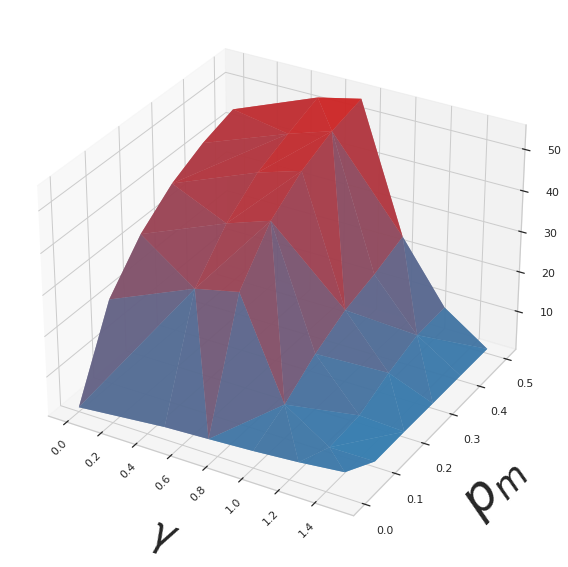

<Figure size 432x288 with 0 Axes>

In [41]:
eps = 0.5
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
for measure in ['avg_ncluster_0.001']:
    print(measure)
    i=0
    x = "gam"
    y = "p_meda"
    data = balanced[balanced["eps"]==eps]
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    surf=ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    # fig.colorbar(surf, shrink=0.5, aspect=6).ax.tick_params(labelsize=22)
    ax.set_xlabel(r'$\gamma$', fontsize=40, labelpad=30)
    ax.set_ylabel(r'$p_m$', fontsize=50, labelpad=30)
    ax.tick_params(axis='x', which='major', labelrotation=45)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.tick_params(axis='z', which='major', pad=10)  
    plt.show()
    plt.savefig(f'nc_balanced_e{eps}_surface.png', bbox_inches="tight")
    plt.show()
    plt.close()
    i+=1        

avg_ncluster_0.001


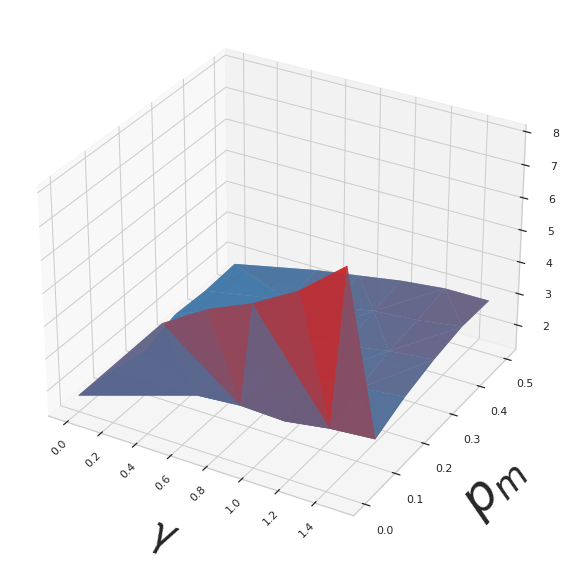

<Figure size 432x288 with 0 Axes>

In [42]:
eps = 0.3
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
for measure in ['avg_ncluster_0.001']:
    print(measure)
    i=0
    x = "gam"
    y = "p_meda"
    data = balanced[balanced["eps"]==eps]
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    surf=ax.plot_trisurf(data['gam'], data['p_media'], data[measure], cmap=cmap, linewidth=0.0, alpha=0.8)
    # fig.colorbar(surf, shrink=0.5, aspect=6).ax.tick_params(labelsize=22)
    ax.set_xlabel(r'$\gamma$', fontsize=40, labelpad=30)
    ax.set_ylabel(r'$p_m$', fontsize=50, labelpad=30)
    ax.tick_params(axis='x', which='major', labelrotation=45)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.tick_params(axis='z', which='major', pad=10)  
    plt.show()
    plt.savefig(f'nc_balanced_e{eps}_surface.png', bbox_inches="tight")
    plt.show()
    plt.close()
    i+=1    

FileNotFoundError: [Errno 2] No such file or directory: 'res/for_spaghetti/for_spaghetti media mo[0.05, 0.5, 0.95] p0.0 e0.3 g0.0 gm0.0 mi1000000.csv'

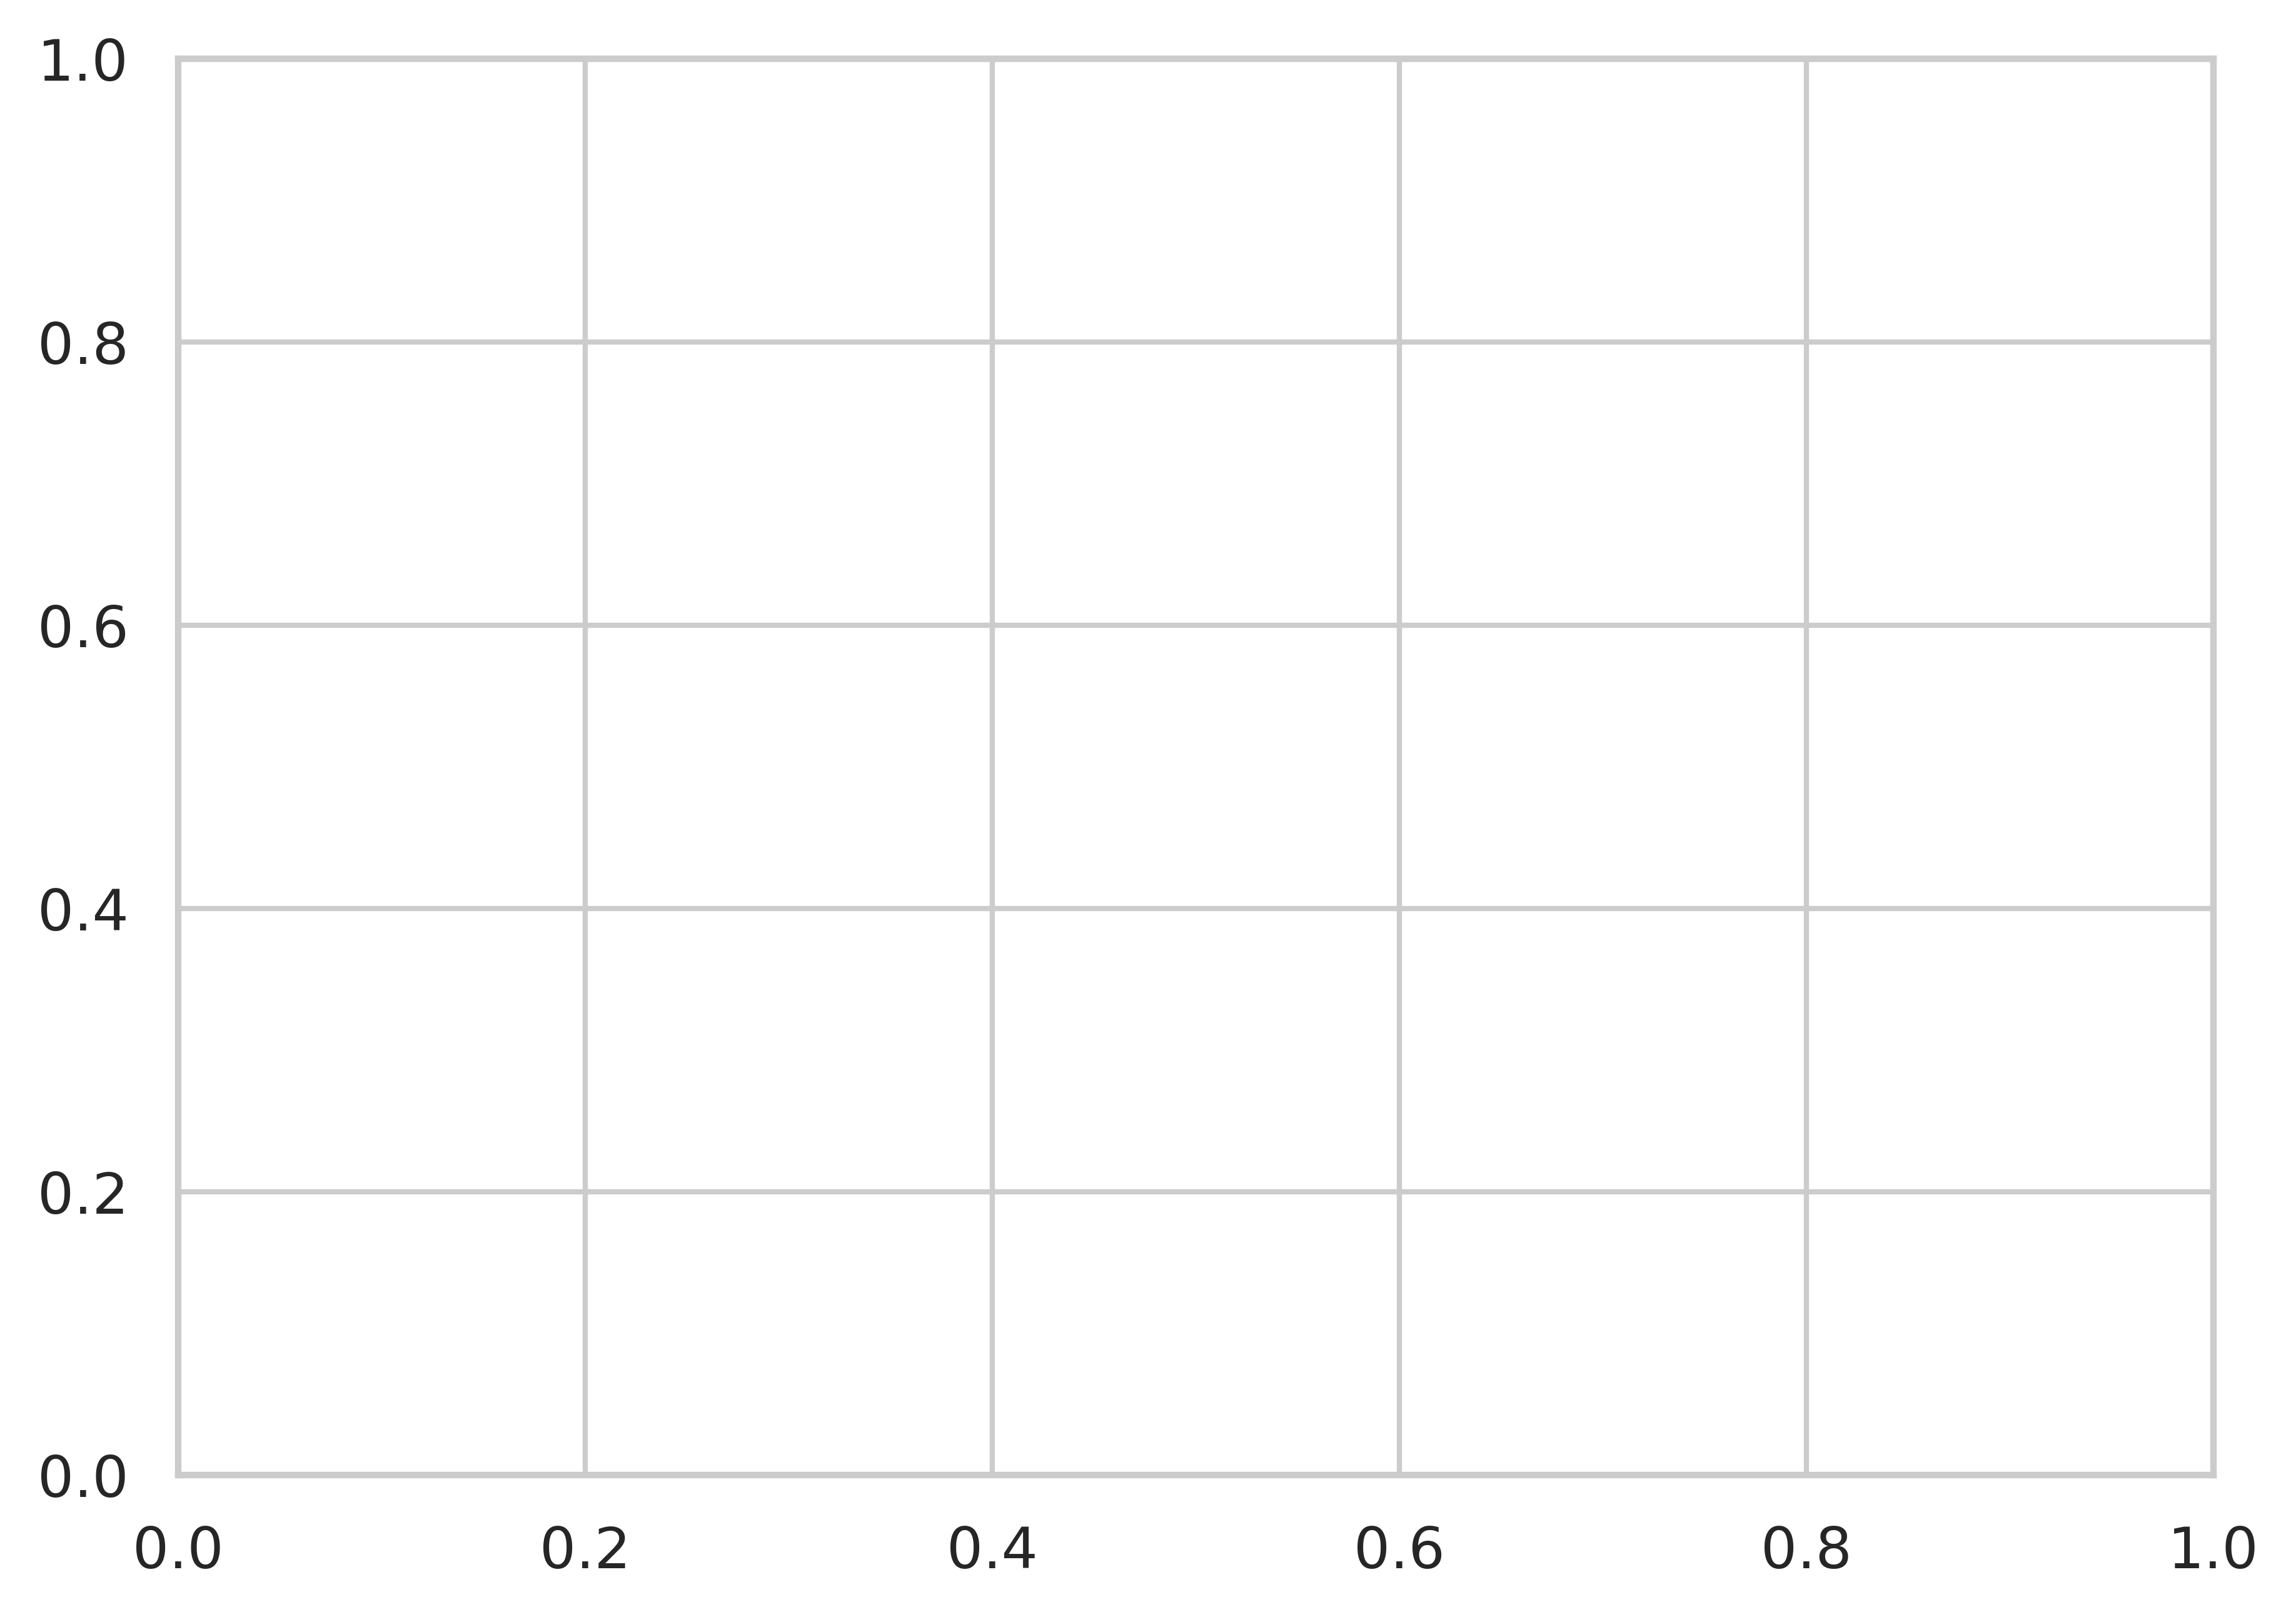

In [43]:
for e in [0.3, 0.4]:
    for g in [0.0, 1.5]:
        for pm in [0.0, 0.5]:
            fig, ax = plt.subplots(nrows=1, ncols=1, dpi=600, figsize=(7, 5))
            mo = '0.05, 0.5, 0.95'
            name = f'for_spaghetti/for_spaghetti media mo[{mo}] p{pm} e{e} g{g} gm{g} mi1000000'
            results = results[results['media_op']==mo]
            results = results[results['eps']==e]
            results = results[results['p_media']==pm]
            iterations = from_res_to_iterations(name, 1)
            evolution(iterations, hex_list, fig=fig, ax=ax)
            plt.axis('off')
            plt.title(r'$\epsilon$='+f'{e},'+r'$\gamma$='+f'{g},'+r'$p_m$='+f'{pm}')
            plt.savefig(f"spaghetti_balanced_pm{pm}_e{e}_g{g}.png", bbox_inches="tight")
            plt.close()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 1), dpi=600)
fig.subplots_adjust(bottom=0.5)

cmap = cmap
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')
cb.outline.set_visible(False)
cb.set_ticks([0.0, 1.0])
plt.savefig("colorbar_opinions.png", bbox_inches="tight")
